![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Roberto Hernandez Ruiz |
<b>Student-nr</b>: 0873235 |
<b>Date</b>: May 28, 2022
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import os
from tensorflow import keras
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils
import pickle
import cv2 

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [2]:
# size of each face after preprocessing
face_size=(47, 47)

In [3]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [4]:
print("{} total images in dataset in data['images'], of shape {}.".format(len(data['images']),data['images'][0].shape))
print("{} total labels in data['target'], list with each person_id.".format(len(data['target'])))

445 total images in dataset in data['images'], of shape (592, 896).
445 total labels in data['target'], list with each person_id.


In [5]:
# display data structure
display(data) #dict with images and labels

{'images': [array([[109, 108, 107, ..., 168, 170, 190],
         [110, 109, 108, ..., 166, 164, 185],
         [110, 109, 109, ..., 175, 171, 188],
         ...,
         [ 77,  76,  75, ..., 163, 160, 186],
         [ 73,  73,  74, ..., 165, 162, 190],
         [ 74,  76,  78, ..., 164, 163, 193]], dtype=uint8),
  array([[65, 61, 60, ..., 33, 24,  5],
         [34, 32, 41, ..., 21, 21, 19],
         [51, 51, 53, ..., 22, 21, 14],
         ...,
         [25, 24, 29, ..., 16,  9,  4],
         [26, 25, 28, ..., 22, 17, 10],
         [25, 26, 31, ..., 15, 15, 13]], dtype=uint8),
  array([[109, 106, 100, ..., 126, 126, 132],
         [104, 105, 104, ..., 133, 129, 137],
         [104, 106, 107, ..., 141, 138, 144],
         ...,
         [102, 102, 102, ..., 178, 182, 206],
         [104, 103, 103, ..., 171, 173, 193],
         [101, 102, 102, ..., 156, 148, 164]], dtype=uint8),
  array([[ 80,  85,  84, ...,  67,  67,  49],
         [ 83,  85,  84, ...,  67,  71,  58],
         [ 90,  83,

### 2. Inspect some images

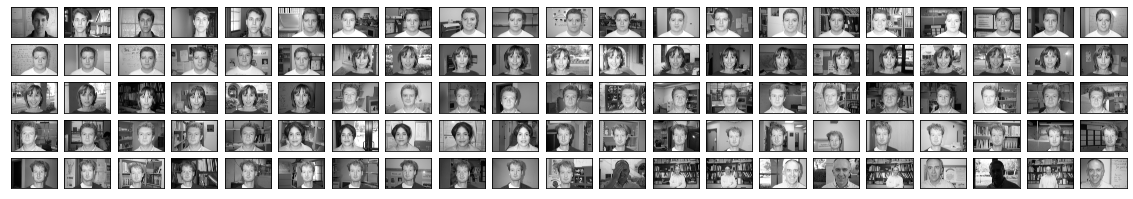

In [6]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [7]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [8]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [9]:
lab, img_per_label = np.unique(targets,return_counts=True)
print("Classes/people: {}.".format(len(lab)))
print("Images per class/person: {}.".format(list(img_per_label)))
assert np.sum(img_per_label) == 440, "Error in nb of images of dataset"

Classes/people: 26.
Images per class/person: [20, 20, 5, 23, 20, 23, 20, 4, 21, 7, 6, 5, 18, 21, 25, 23, 4, 21, 18, 26, 20, 20, 22, 5, 21, 22].


In [10]:
# only for my info
print(faces["data"].shape) # N images x flattened 47x47 image
print(faces["images"].shape) # N images x 47x47 image x 1 channel
print(faces["labels"].shape) # N original labels 'person_003'
print(faces["target"].shape) # N transformed labels (label-encoded)

(440, 2209)
(440, 47, 47, 1)
(440,)
(440,)


In [11]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1] #vector of each flattened image 47x47

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

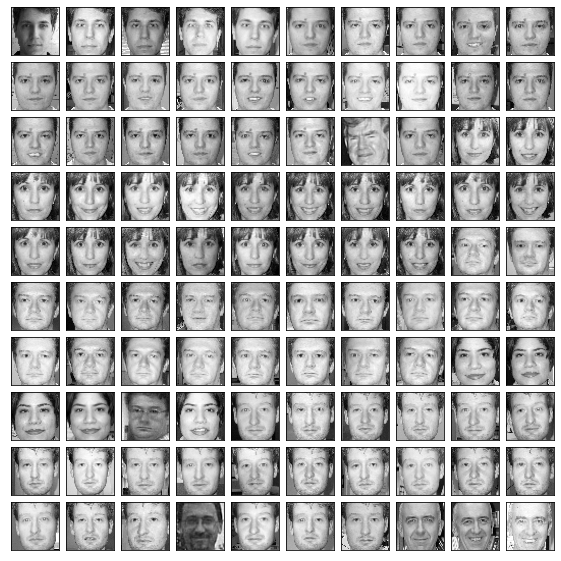

In [12]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [13]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [14]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

DESC = FeatureDescriptor.PCA

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features)) #440 samples,2209 features
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    print("PCA results:",X_pca.shape) # to see shape
    dist_metric_pca = euclidean
    

num_components 35
PCA results: (440, 35)


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

DESC = FeatureDescriptor.LDA

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    print("LDA results:",X_lda.shape) #to see shape
    dist_metric_lda = euclidean
    

LDA results: (440, 25)


### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [16]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

DESC = FeatureDescriptor.LBP


# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:
def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp = desc.describe_list(faces.images[...,0])
    print("LBP results:",embedded_lbp.shape)
    dist_metric_lbp = CHI2 #chisquare gave some problems
    

LBP results: (440, 490)


### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [18]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import warnings
warnings.filterwarnings("ignore")
import localmodules.siamese as siamese


encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          894400      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         

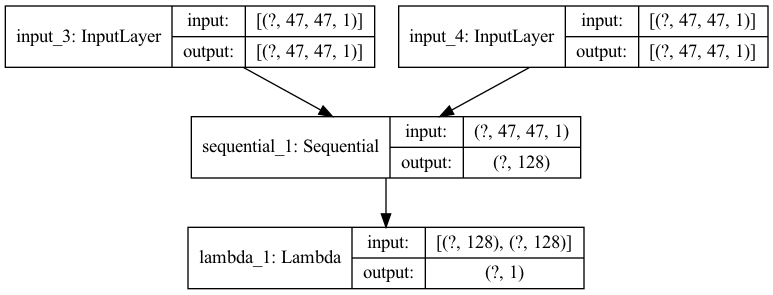

In [19]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='output_imgs/model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [20]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

DESC = FeatureDescriptor.DL

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
        
    files = os.listdir("./")
    # TRAIN ONLY IF THERE IS NO SAVED MODEL IN THE FOLDER
    if 'original_model.h5' in files:
        # If just to perform inference and not further optimization or training,ignore the loss function
        model = keras.models.load_model('original_model.h5', compile=False) 
        #model = keras.models.load_model('original_model.h5',custom_objects={'contrastive_loss': siamese.contrastive_loss})
        
    else: 
        model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
        model.save('original_model.h5')
        
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc)) #0.994 in my experiment
    embedded_dl = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric_dl = euclidean
    

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 - 52s - loss: 0.1017 - accuracy: 0.7294 - val_loss: 0.0457 - val_accuracy: 0.9125
Epoch 2/10
1200/1200 - 51s - loss: 0.0379 - accuracy: 0.9383 - val_loss: 0.0264 - val_accuracy: 0.9688
Epoch 3/10
1200/1200 - 53s - loss: 0.0214 - accuracy: 0.9844 - val_loss: 0.0204 - val_accuracy: 0.9875
Epoch 4/10
1200/1200 - 51s - loss: 0.0153 - accuracy: 0.9901 - val_loss: 0.0172 - val_accuracy: 0.9906
Epoch 5/10
1200/1200 - 53s - loss: 0.0106 - accuracy: 0.9959 - val_loss: 0.0159 - val_accuracy: 0.9906
Epoch 6/10
1200/1200 - 52s - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.0134 - val_accuracy: 0.9906
Epoch 7/10
1200/1200 - 52s - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.0125 - val_accuracy: 0.9937
Epoch 8/10
1200/1200 - 52s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9937
Epoch 9/10
1200/1200 - 52s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9875
Epoch 10/10
1200/1200 - 53

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

In [21]:
# Only for visualize info before the exercises
print(faces.data.shape) # N images x flattened 47x47 image
print(faces.images.shape) # N images x 47x47 image x 1 channel
print(faces.labels.shape) # N original labels 'person_003'
print(faces.target.shape) # N transformed labels (label-encoded)
#faces["target"]

(440, 2209)
(440, 47, 47, 1)
(440,)
(440,)


<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [22]:
def pairwise_distances(embedded,dist_metric,targets):
    distances = list()
    
    EPS = np.finfo(float).eps
    for i in range(embedded.shape[0]):
        for j in range(embedded.shape[0]):
            if i!=j:
                dist = dist_metric(embedded[i],embedded[j])
                dist = 1/(EPS+dist) # to avoid division by 0
                distances.append([targets[i], targets[j],dist])
    
    df = pd.DataFrame(distances, columns=['T1', 'T2', 'distances'])
    dist_matrix = df.pivot_table(index='T1', columns='T2',values='distances')

    return dist_matrix


# Show one of them
dist_matrix_pca = pairwise_distances(embedded_pca,euclidean,faces.target)
dist_matrix_pca.head()
# Check correct generation of df
#combs,_ = np.unique(faces.target,return_counts=True)
#assert dist_matrix_pca.shape[0] == dist_matrix_pca.shape[1] == len(combs), "Matrix shape does not match to the number of distinct targets."


T2,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
T1,,,,,,,,,,,,,,,,,,,,,
0,0.165456,0.128927,0.117150,0.129898,0.121581,0.121430,0.132477,0.111953,0.113850,0.117985,...,0.110515,0.135425,0.108122,0.114195,0.126228,0.127852,0.117128,0.111254,0.121034,0.139340
1,0.128927,0.211784,0.134977,0.150043,0.132582,0.134375,0.152957,0.113697,0.123691,0.129794,...,0.113548,0.152734,0.115033,0.125179,0.139284,0.137301,0.128118,0.115105,0.132139,0.145639
2,0.117150,0.134977,0.132194,0.121826,0.117390,0.122282,0.127387,0.104613,0.111311,0.108946,...,0.099129,0.131683,0.114240,0.107876,0.119992,0.118174,0.119680,0.113962,0.118168,0.128245
3,0.129898,0.150043,0.121826,0.181040,0.128189,0.129074,0.145442,0.120790,0.118992,0.122174,...,0.106778,0.138539,0.112775,0.121140,0.132879,0.137216,0.126936,0.120762,0.128387,0.136381
4,0.121581,0.132582,0.117390,0.128189,0.197983,0.124634,0.133300,0.111852,0.116119,0.115029,...,0.105536,0.134881,0.110047,0.114681,0.127722,0.128113,0.122197,0.112299,0.122810,0.134867


In [23]:
# Compute pairwise_distance matrixes for all 4 techniques if they are not stored
# Otherwise, load them

# PCA
try:
    with open("dist_matrix_pca.pkl","rb") as f:
        dist_matrix_pca = pickle.load(f)
        print("Distances matrix for PCA loaded.")
except:
    dist_matrix_pca = pairwise_distances(embedded_pca,euclidean,faces.target)    
    with open("dist_matrix_pca.pkl",'wb') as f:
        pickle.dump(dist_matrix_pca,f)
        print("PCA distances matrix saved.")

# LDA       
try:            
    with open("dist_matrix_lda.pkl","rb") as r:
        dist_matrix_lda = pickle.load(r)
        print("Distances matrix for LDA loaded.")
except:
    dist_matrix_lda = pairwise_distances(embedded_lda,euclidean,faces.target) 
    with open("dist_matrix_lda.pkl",'wb') as r:
        pickle.dump(dist_matrix_lda,r)
        print("LDA distances matrix saved.")
        
# LBP  
try:       
    with open("dist_matrix_lbp.pkl","rb") as l:
        dist_matrix_lbp = pickle.load(l)
        print("Distances matrix for LBP loaded.")
except:
    dist_matrix_lbp = pairwise_distances(embedded_lbp,CHI2,faces.target)
    with open("dist_matrix_lbp.pkl",'wb') as l:
        pickle.dump(dist_matrix_lbp,l)
        print("LBP distances matrix saved.")
# DL       
try:               
    with open("dist_matrix_dl.pkl","rb") as p:
        dist_matrix_dl = pickle.load(p)
        print("Distances matrix for DL Siamese Network loaded.")
except:        
    dist_matrix_dl = pairwise_distances(embedded_dl,euclidean,faces.target)
    with open("dist_matrix_dl.pkl",'wb') as p:
        pickle.dump(dist_matrix_dl,p)
        print("DL Siamese Network distances matrix saved.") 
    

PCA distances matrix saved.
LDA distances matrix saved.
LBP distances matrix saved.
DL Siamese Network distances matrix saved.


## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

In [24]:
# FROM ASSIGNMENT 1
def sim2scores(similarity_matrix):
    # use .values to access as numpy array
    np_similarity_matrix = similarity_matrix.values

    # grab elements on the diagonal
    genuine_scores = np.diag(np_similarity_matrix)

    # mask elements that are on the diagonal, retain non-diagonal elements
    imposter_scores =  np_similarity_matrix[~np.eye(np_similarity_matrix.shape[0],dtype=bool)]

    # store in one single list of scores as required for the classification validation procedures
    scores = np.append(np.array(genuine_scores), np.array(imposter_scores))

    # normalize to [0,1] range, 0 corresponding to minimal similarity
    scores = (scores - scores.min())/(scores.max()-scores.min())

    ## add the genuine and imposter labels

    # tag genuine combinations as label 1 and imposter combinations as 0

    genuine_id = np.zeros_like(scores)
    genuine_id[0:genuine_scores.shape[0]] = 1

    return genuine_id, scores

In [25]:
# Convert the similarities between classes from similarities (1/distances) to scores
genuine_id_pca, scores_pca = sim2scores(dist_matrix_pca)
genuine_id_lda, scores_lda = sim2scores(dist_matrix_lda)
genuine_id_lbp, scores_lbp = sim2scores(dist_matrix_lbp)
genuine_id_dl, scores_dl = sim2scores(dist_matrix_dl)

assert genuine_id_pca.shape == genuine_id_lda.shape == genuine_id_lbp.shape == genuine_id_dl.shape, "Error in ids"
assert scores_pca.shape == scores_lda.shape == scores_lbp.shape == scores_dl.shape, "Error in scores"

In [26]:
# See distribution of genuine/impostors in PCA example
    #class 0: impostors 650 + class 1: genuines 26
print("Scores distribution by class:",np.unique(genuine_id_pca,return_counts=True)) 
print("Scores per technique:",scores_pca.shape[0]) #26x26 classes = 676 scores (class i vs class j)

# Distribute scores in different arrays for genuine/impostors for each technique
def distr_scores(ids,scores):
    genuine_scores = scores[ids==1] # Genuine should be the scores of positions id=1   
    impostor_scores = scores[ids==0] # Impostors should be the scores of positions id=0
    return genuine_scores,impostor_scores
 
pca_genuines,pca_impostors = distr_scores(genuine_id_pca,scores_pca) #PCA
lda_genuines, lda_impostors = distr_scores(genuine_id_lda,scores_lda) #LDA
lbp_genuines,lbp_impostors = distr_scores(genuine_id_lbp,scores_lbp) #LBP
dl_genuines,dl_impostors = distr_scores(genuine_id_dl,scores_dl) #DL

    # Check all the same (26 genuines and 650 impostors)
print("PCA:",len(pca_genuines),"genuine scores and",len(pca_impostors),"impostor scores.")
print("LDA:",len(lda_genuines),"genuine scores and",len(lda_impostors),"impostor scores.")
print("LBP:",len(lbp_genuines),"genuine scores and",len(lbp_impostors),"impostor scores.")
print("DL:",len(dl_genuines),"genuine scores and",len(dl_impostors),"impostor scores.")
    # Visualize mean for info only, genuines of course should be higher
#print(np.mean(pca_genuines))
#print(np.mean(pca_impostors))

Scores distribution by class: (array([0., 1.]), array([650,  26]))
Scores per technique: 676
PCA: 26 genuine scores and 650 impostor scores.
LDA: 26 genuine scores and 650 impostor scores.
LBP: 26 genuine scores and 650 impostor scores.
DL: 26 genuine scores and 650 impostor scores.


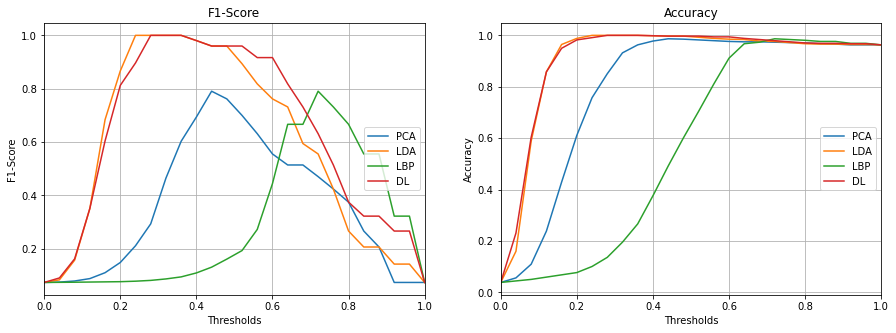

In [27]:
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, precision_score

# First use thresholds from precision_recall_curve (ASSIGNM.1)
precision_pca, recall_pca, thresh_pca = precision_recall_curve(genuine_id_pca,scores_pca)
precision_lda, recall_lda, thresh_lda = precision_recall_curve(genuine_id_lda,scores_lda)
precision_lbp, recall_lbp, thresh_lbp = precision_recall_curve(genuine_id_lbp,scores_lbp)
precision_dl, recall_dl, thresh_dl = precision_recall_curve(genuine_id_dl,scores_dl)
# Retrieve thresholds from ROC CURVE (ASSIGNM.1)
fpr_pca, tpr_pca, thresh_pca_2 = roc_curve(genuine_id_pca,scores_pca)
fpr_lda, tpr_lda, thresh_lda_2 = roc_curve(genuine_id_lda,scores_lda)
fpr_lbp, tpr_lbp, thresh_lbp_2 = roc_curve(genuine_id_lbp,scores_lbp)
fpr_dl, tpr_dl, thresh_dl_2 = roc_curve(genuine_id_dl,scores_dl)

# To check equal dims
precision_pca,recall_pca = precision_pca[:-1], recall_pca[:-1]
precision_lda,recall_lda = precision_lda[:-1], recall_lda[:-1]
precision_lbp,recall_lbp = precision_lbp[:-1], recall_lbp[:-1]
precision_dl,recall_dl = precision_dl[:-1], recall_dl[:-1]

# Number of thresholds for each technique is different: in 2nd set less difference 
#print(len(thresh_pca),len(thresh_lda),len(thresh_lbp),len(thresh_dl)) #!!!!!!
#print(len(thresh_pca_2),len(thresh_lda_2),len(thresh_lbp_2),len(thresh_dl_2)) #!!!!!!

# Therefore, 
thresh = np.linspace(0,1,len(pca_genuines)) #26 equidistant


# ACCURACY CALCULATION FROM ASSIGNMENT 1: F1_SCORE ADDED 
def calculate_acc(thresholds, genuine_scores, impostor_scores):
    acc = []
    f1_scores = []
    # for each threshold
    for t in thresholds:
        FP, FN, TP, TN = 0, 0, 0, 0

        for score in impostor_scores:
            if score >= t:
                FP += 1 # impostor misclassified as genuine
            else:
                TN += 1 # impostor correctly rejected

        for score in genuine_scores:
            if score >= t:
                TP += 1 # genuine correctly identified
            else:
                FN += 1 # genuine incorrectly rejected

        acc_t = float(TP + TN) / float(TP + TN + FP +FN)
        acc.append(acc_t)
        
        # NEW: ADDED TO COMPUTE F1-SCORE
        precision = TP / float(TP+FP)
        recall = TP / float(TP+FN)
        F1 = 2*(precision*recall)/(precision+recall)      
        f1_scores.append(F1)

    return np.array(acc),np.array(f1_scores)

acc_pca, f1_score_pca = calculate_acc(thresh,pca_genuines,pca_impostors)
acc_lda, f1_score_lda = calculate_acc(thresh,lda_genuines,lda_impostors)
acc_lbp, f1_score_lbp = calculate_acc(thresh,lbp_genuines,lbp_impostors)
acc_dl, f1_score_dl = calculate_acc(thresh,dl_genuines,dl_impostors)

fig = plt.figure(figsize=(15, 5))

# Plot F1-Scores
fig.add_subplot(1, 2, 1)
plt.plot(thresh,f1_score_pca,label='PCA');
plt.plot(thresh,f1_score_lda,label='LDA');
plt.plot(thresh,f1_score_lbp,label='LBP');
plt.plot(thresh,f1_score_dl,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("F1-Score", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("F1-Score")
  
# Plot accuracies
fig.add_subplot(1, 2, 2)
plt.plot(thresh,acc_pca,label='PCA');
plt.plot(thresh,acc_lda,label='LDA');
plt.plot(thresh,acc_lbp,label='LBP');
plt.plot(thresh,acc_dl,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("Accuracy", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("Accuracy");
plt.savefig("f1_accuracy.png")

APPROACH 1: USING F1-SCORES
PCA: Optimal threshold 0.44 - (max F1-score = 0.7907).
LDA: Optimal threshold 0.24 - (max F1-score = 1.0).
LBP: Optimal threshold 0.72 - (max F1-score = 0.7907).
DL: Optimal threshold 0.28 - (max F1-score = 1.0).

APPROACH 2: USING G-MEAN AND ROC CURVES
PCA Optimal threshold 0.332 - max G-Mean 0.857
	Optimal FPR: 0.046, Optimal TPR: 0.769
LDA Optimal threshold 0.369 - max G-Mean 1.0
	Optimal FPR: 0.0, Optimal TPR: 1.0
LBP Optimal threshold 0.621 - max G-Mean 0.934
	Optimal FPR: 0.055, Optimal TPR: 0.923
DL Optimal threshold 0.365 - max G-Mean 1.0
	Optimal FPR: 0.0, Optimal TPR: 1.0

Only for info: max accuracies...
Max accuracy PCA:  0.98669
Max accuracy LDA:  1.0
Max accuracy LBP:  0.98669
Max accuracy DL:  1.0


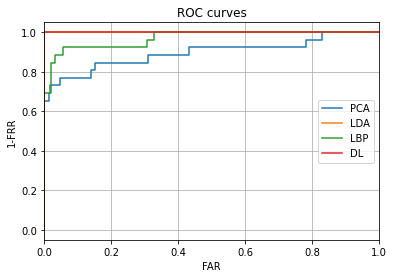

In [31]:
#Determine some optimal threshold (look up in classification literature)
# 2 different approaches: from F1-score curves and from ROC curves

# APPROACH 1: USING F1-SCORES. AS IN ASSIGNMENT 1
"""Calculate the threshold for which F1 is maximal.""" #This was done in Assignment 1
def optimal_threshold_f1score(f1_scores,thresholds,metric):
    max_f1_score = max(f1_scores)
    res = np.where(f1_scores == max_f1_score)
    optimal_threshold = round(thresholds[res[0][0]],5)
    print("{}: Optimal threshold {} - (max F1-score = {}).".format(metric,optimal_threshold,round(max_f1_score,5)))
    
print("APPROACH 1: USING F1-SCORES")
optimal_threshold_f1score(f1_score_pca,thresh,"PCA")
optimal_threshold_f1score(f1_score_lda,thresh,"LDA")
optimal_threshold_f1score(f1_score_lbp,thresh,"LBP")
optimal_threshold_f1score(f1_score_dl,thresh,"DL")

# APPROACH 2: USING G-MEAN AND ROC CURVES. From literature
# https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
def optimal_threshold_gmean(tpr,fpr,thresholds,metric):    
    # Extract g_mean: np.sqrt(recall * specificity or TNR)
    gmean = np.sqrt(tpr * (1 - fpr)) 
    # Find the optimal threshold
    index = np.argmax(gmean)
    optimal_threshold = round(thresholds[index], 3)
    optimal_gmean = round(gmean[index], 3)
    optimal_fpr = round(fpr[index], 3)
    optimal_tpr = round(tpr[index], 3)
    
    print('{} Optimal threshold {} - max G-Mean {}'.format(metric,optimal_threshold, optimal_gmean))
    print('\tOptimal FPR: {}, Optimal TPR: {}'.format(optimal_fpr, optimal_tpr))

print("\nAPPROACH 2: USING G-MEAN AND ROC CURVES")
optimal_threshold_gmean(tpr_pca,fpr_pca,thresh_pca_2,"PCA")
optimal_threshold_gmean(tpr_lda,fpr_lda,thresh_lda_2,"LDA")
optimal_threshold_gmean(tpr_lbp,fpr_lbp,thresh_lbp_2,"LBP")
optimal_threshold_gmean(tpr_dl,fpr_dl,thresh_dl_2,"DL")

# Print max accuracies: but we know for imbalanced problems it is not a good performance metric
print("\nOnly for info: max accuracies...")
print("Max accuracy PCA: ",round(max(acc_pca),5))
print("Max accuracy LDA: ",round(max(acc_lda),5))
print("Max accuracy LBP: ",round(max(acc_lbp),5))
print("Max accuracy DL: ",round(max(acc_dl),5))

# Approach 2 results make sense if we visualize ROC curve
plt.plot(fpr_pca, tpr_pca,label="PCA");
plt.plot(fpr_lda, tpr_lda,label='LDA');
plt.plot(fpr_lbp, tpr_lbp,label='LBP');
plt.plot(fpr_dl, tpr_dl,label='DL');
plt.xlabel("FAR", size=10)
plt.ylabel("1-FRR", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("ROC curves");
#plt.savefig("roc_curves.png");

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

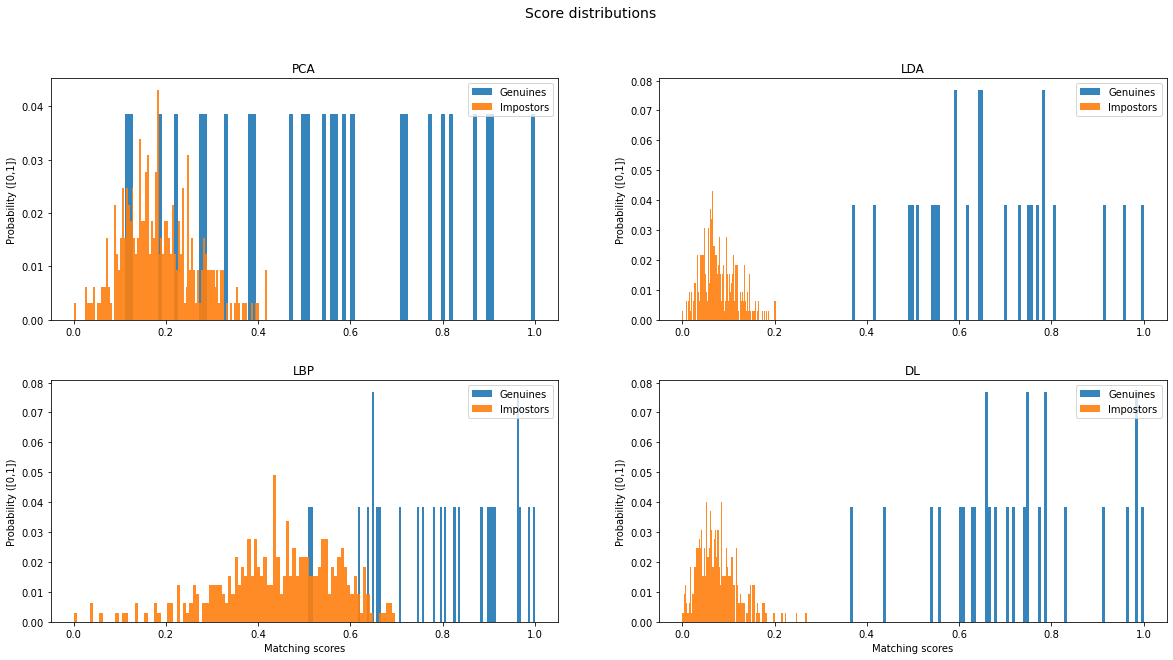

In [32]:
# SAME AS FROM ASSIGNMENT 1
fig = plt.figure(figsize=(20, 10))
# PCA
fig.add_subplot(2, 2, 1)
plt.hist(pca_genuines, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(pca_genuines)) / len(pca_genuines));
plt.hist(pca_impostors, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(pca_impostors)) / len(pca_impostors));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("PCA")
plt.legend(loc='upper right');
  
# LDA
fig.add_subplot(2, 2, 2) 
plt.hist(lda_genuines, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(lda_genuines)) / len(lda_genuines));
plt.hist(lda_impostors, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lda_impostors)) / len(lda_impostors));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LDA")
plt.legend(loc='upper right');

# LBP
fig.add_subplot(2, 2, 3)
plt.hist(lbp_genuines, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(lbp_genuines)) / len(lbp_genuines));
plt.hist(lbp_impostors, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lbp_impostors)) / len(lbp_impostors));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LBP")
plt.legend(loc='upper right');
  
# DL
fig.add_subplot(2, 2, 4) 
plt.hist(dl_genuines, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(dl_genuines)) / len(dl_genuines));
plt.hist(dl_impostors, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(dl_impostors)) / len(dl_impostors));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("DL")
plt.legend(loc='upper right');
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Score distributions",fontsize=14);
plt.savefig("output_imgs/score_distributions.png")

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

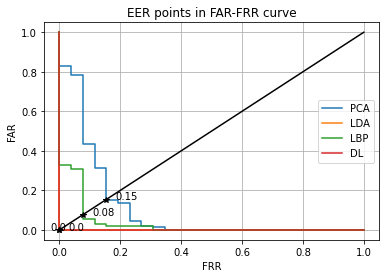

In [33]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# FROM ASSIGNMENT 1: Retrieve FPR and TPR extracted before in ROC curve
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve.""" 
# EER computation #https://yangcha.github.io/EER-ROC/
eer_pca = brentq(lambda x : 1. - x - interp1d(fpr_pca, tpr_pca)(x), 0., 1.)
eer_lda = brentq(lambda x : 1. - x - interp1d(fpr_lda, tpr_lda)(x), 0., 1.)
eer_lbp = brentq(lambda x : 1. - x - interp1d(fpr_lbp, tpr_lbp)(x), 0., 1.)
eer_dl = brentq(lambda x : 1. - x - interp1d(fpr_dl, tpr_dl)(x), 0., 1.)

# Plot the equal error rate in FAR-FRR curve 
plt.plot(1-tpr_pca,fpr_pca, label="PCA");
plt.plot(1-tpr_lda,fpr_lda, label="LDA");
plt.plot(1-tpr_lbp,fpr_lbp, label="LBP");
plt.plot(1-tpr_dl,fpr_dl, label="DL");
plt.plot(fpr_pca,fpr_pca,color='black')
# EERs
plt.plot(eer_pca, eer_pca, 'k*')
plt.text(eer_pca+0.03,eer_pca,round(eer_pca,2))
plt.plot(eer_lda, eer_lda, 'k*')
plt.text(eer_lda-0.03,eer_lda,round(eer_lda,2))
plt.plot(eer_lbp, eer_lbp, 'k*')
plt.text(eer_lbp+0.03,eer_lbp,round(eer_lbp,2))
plt.plot(eer_dl, eer_dl, 'k*')
plt.text(eer_dl+0.03,eer_dl,round(eer_dl,2))
plt.xlabel("FRR", size=10)
plt.ylabel("FAR", size=10)
plt.legend()
plt.title("EER points in FAR-FRR curve")
plt.grid()
plt.savefig("output_imgs/eer_far_frr_curve.png")

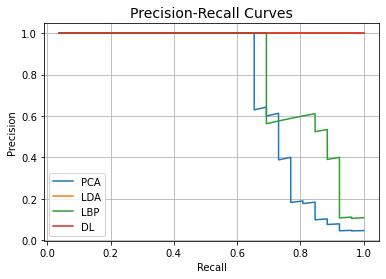

In [34]:
# FROM ASSIGNMENT 1
"""Calculate and plot the Precision-Recall curve for this system"""
plt.plot(recall_pca,precision_pca,label='PCA');
plt.plot(recall_lda,precision_lda,label='LDA');
plt.plot(recall_lbp,precision_lbp,label='LBP');
plt.plot(recall_dl,precision_dl,label='DL');
plt.xlabel("Recall", size=10)
plt.ylabel("Precision", size=10)
plt.grid()
plt.legend()
plt.title("Precision-Recall Curves",fontsize=14);
plt.savefig("output_imgs/pr_curves.png")

In [35]:
from sklearn.metrics import auc, average_precision_score
# FROM ASSIGNMENT 1
"""Calculate the Area Under the PR-curve."""
auc_pr_pca = auc(recall_pca,precision_pca)
print("Area Under the PR-curve (PCA):",auc_pr_pca)
auc_pr_lda = auc(recall_lda,precision_lda)
print("Area Under the PR-curve (LDA):",auc_pr_lda)
auc_pr_lbp = auc(recall_lbp,precision_lbp)
print("Area Under the PR-curve (LBP):",auc_pr_lbp)
auc_pr_dl = auc(recall_dl,precision_dl)
print("Area Under the PR-curve (DL):",auc_pr_dl)

Area Under the PR-curve (PCA): 0.7027006805766031
Area Under the PR-curve (LDA): 0.9615384615384616
Area Under the PR-curve (LBP): 0.7881021233869892
Area Under the PR-curve (DL): 0.9615384615384616


In [36]:
# FROM ASSIGNMENT 1
"""Calculate the average precision scores"""

avg_precision_pca = average_precision_score(genuine_id_pca,scores_pca)
print("Average precision score (PCA):",avg_precision_pca)
avg_precision_lda = average_precision_score(genuine_id_lda,scores_lda)
print("Average precision score (LDA):",avg_precision_lda)
avg_precision_lbp = average_precision_score(genuine_id_lbp,scores_lbp)
print("Average precision score (LBP):",avg_precision_lbp)
avg_precision_dl = average_precision_score(genuine_id_dl,scores_dl)
print("Average precision score (DL):",avg_precision_dl)

Average precision score (PCA): 0.7423760460351566
Average precision score (LDA): 1.0
Average precision score (LBP): 0.8280550825523464
Average precision score (DL): 1.0


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

Rank-1 Recognition Rate (PCA) 0.8461538461538461
Rank-1 Recognition Rate (LDA) 1.0
Rank-1 Recognition Rate (LBP) 0.8846153846153846
Rank-1 Recognition Rate (DL) 1.0


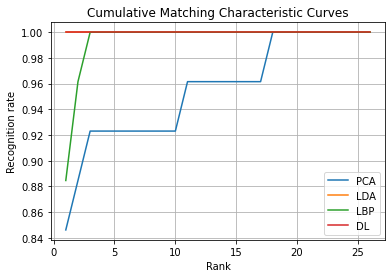

In [37]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library. Adapted from Assignment 1

def cumulative_matching_characteristic(similarity_matrix):

    np_similarity_matrix = np.copy(similarity_matrix.values)
    genuine_scores = np.diag(similarity_matrix.values)
    
    # Order test samples (rows) from higher to lower similarity score
    for i in range (np_similarity_matrix.shape[1]):
        np_similarity_matrix[i] = np.sort(np_similarity_matrix[i])[::-1]
        
    # Return position of genuine score from Ground Truth
    genuine_position = list()
    for i in range (np_similarity_matrix.shape[1]):
        pos = np.where(np_similarity_matrix[i] == genuine_scores[i])[0][0] 
        genuine_position.append(pos)
        
    # For each rank, calculate nbTimes_genuine_position_underRank / totalNbRows
    recogn_rates = list()
    for n in range (len(genuine_scores)):
        cum = 0
        for p in genuine_position:
            if p <= n:
                cum = cum + 1
        rate_n = cum / len(genuine_position) 
        recogn_rates.append(rate_n)

    # Rank-1 Recognition rate
    rank_1 = recogn_rates[0]

    return recogn_rates, rank_1

ranks = list(range(1,n_classes+1))
recognition_rate_pca, rank_1_pca = cumulative_matching_characteristic(dist_matrix_pca)
recognition_rate_lda,rank_1_lda = cumulative_matching_characteristic(dist_matrix_lda)
recognition_rate_lbp,rank_1_lbp = cumulative_matching_characteristic(dist_matrix_lbp)
recognition_rate_dl,rank_1_dl = cumulative_matching_characteristic(dist_matrix_dl)
# Plot CMC curve
plt.plot(ranks, recognition_rate_pca, label = "PCA")
plt.plot(ranks, recognition_rate_lda, label = "LDA")
plt.plot(ranks, recognition_rate_lbp, label = "LBP")
plt.plot(ranks, recognition_rate_dl, label = "DL")
plt.xlabel('Rank')
plt.ylabel('Recognition rate')
plt.title('Cumulative Matching Characteristic Curves')
plt.legend()
plt.grid()
plt.savefig("output_imgs/cmc_curves.png")
print("Rank-1 Recognition Rate (PCA)",rank_1_pca)
print("Rank-1 Recognition Rate (LDA)",rank_1_lda)
print("Rank-1 Recognition Rate (LBP)",rank_1_lbp)
print("Rank-1 Recognition Rate (DL)",rank_1_dl)

## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice (chosen exercises in bold)
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. **Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)**
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. **Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.)**
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

# ---------------------------------

# Exercise 1.
### Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)

In [42]:
from sklearn.datasets import fetch_lfw_people,fetch_olivetti_faces

In [397]:
try:
    with open("at_faces.pkl","rb") as f:
        at_faces = pickle.load(f)
        print("Dataset AT&T loaded.")
except:
    at_faces = fetch_olivetti_faces(shuffle=False, random_state=0, download_if_missing=True)

    with open("at_faces.pkl",'wb') as f:
        pickle.dump(at_faces,f)
        print("at_faces saved.")

try:
    with open("fetch_faces.pkl","rb") as n:
        fetch_faces = pickle.load(n)
        print("Dataset fetchLFW loaded.")
except:
    fetch_faces = fetch_lfw_people(resize=0.5, color=False)

    with open("fetch_faces.pkl",'wb') as n:
        pickle.dump(fetch_faces,n)
        print("Dataset fetchLFW saved.")

Dataset AT&T loaded.
Dataset fetchLFW loaded.


## a) AT&T dataset

Images shape (n_samples,dim1,dim2,dim3): (400, 64, 64, 1)
400 associated labels.
40 classes.


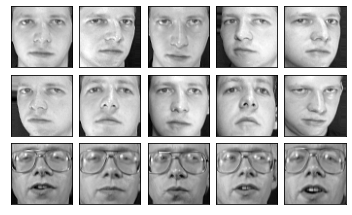

In [398]:
# Retrieve images and labels. Dataset exploration
att_imgs = at_faces["images"] 
att_images = list() 
at_img_size = at_faces["images"].shape[1:] #(64,64) initially

# Add 3rd dim
for i,img in enumerate(att_imgs):
    img = np.resize(img,at_img_size + (1,))
    att_images.append(img)
                    
# resized images
att_images = np.array(att_images)
print("Images shape (n_samples,dim1,dim2,dim3):",att_images.shape)
att_labels = at_faces["target"]
print("{} associated labels.".format(att_labels.shape[0])) #10 images per class x 40 classes = 400 
n_classes_at = at_faces.target.max() +1
print(n_classes_at,"classes.")

# See some images
fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111,nrows_ncols=(3, 5), axes_pad=0.1)
for ax, im in zip(grid, att_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [399]:
# Retrieve all embeddeds to construct distance matrixes
    # PCA
num_components = 35
n_components = min(num_components, min(at_faces.data.shape[0],at_faces.data.shape[1]))
desc = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(at_faces.data)
X_pca_at = desc.transform(at_faces.data)
embedded_pca_at = X_pca_at
print("Embedded PCA shape:",embedded_pca_at.shape) # (400 images x 35 components as expected)

    # LDA
num_components = min(num_components, min(n_classes_at - 1, at_faces.data.shape[1]))
desc = LinearDiscriminantAnalysis(n_components=num_components).fit(at_faces.data, att_labels)
X_lda_at = desc.fit_transform(at_faces.data, att_labels)
embedded_lda_at = X_lda_at
print("Embedded LDA shape:",embedded_lda_at.shape)

    # LBP (same params)
desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_lbp_at = desc.describe_list(at_faces.images)
print("Embedded LBP shape:",embedded_lbp_at.shape)

Embedded PCA shape: (400, 35)
Embedded LDA shape: (400, 35)
Embedded LBP shape: (400, 490)


In [403]:
#DL: Siamese networks
imshape = att_images.shape[1:] #(64,64,1)
# Create model and split data
encoder_at, model_at = siamese.create_siamese_model(imshape)
x_train_at, x_test_at, y_train_at, y_test_at = holdout_split(*siamese.get_siamese_paired_data(att_images, att_labels))
# Learning process configuration
model_at.compile(loss=siamese.contrastive_loss, optimizer=Adam(), metrics = [siamese.accuracy],run_eagerly=True)

# Load or train the model
epochs = 10
if "model_at_faces.h5" in files:
    model_at = keras.models.load_model("model_at_faces.h5",compile=False)
else:
    model_at.fit([x_train_at[:, 0], x_train_at[:, 1]], y_train_at, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    model_at.save("model_at_faces.h5")
    print("Model ATT saved.")
    
# Prediction and embedded_dl extraction    
test_scores_at = model_at.predict([x_test_at[:, 0], x_test_at[:, 1]])
test_acc_at = accuracy_score(y_test_at, test_scores_at > 0.5)
print("Accuracy on the test set: {}".format(test_acc_at)) #Accuracy on the test set: 0.955
embedded_dl_at = encoder_at(att_images.astype(np.float32)).numpy()

Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 - 125s - loss: 0.1560 - accuracy: 0.6094 - val_loss: 0.0879 - val_accuracy: 0.7281
Epoch 2/10
1280/1280 - 118s - loss: 0.0833 - accuracy: 0.7367 - val_loss: 0.0670 - val_accuracy: 0.8000
Epoch 3/10
1280/1280 - 119s - loss: 0.0576 - accuracy: 0.8422 - val_loss: 0.0471 - val_accuracy: 0.9000
Epoch 4/10
1280/1280 - 121s - loss: 0.0462 - accuracy: 0.8867 - val_loss: 0.0422 - val_accuracy: 0.9250
Epoch 5/10
1280/1280 - 119s - loss: 0.0403 - accuracy: 0.9187 - val_loss: 0.0385 - val_accuracy: 0.9281
Epoch 6/10
1280/1280 - 103s - loss: 0.0365 - accuracy: 0.9281 - val_loss: 0.0359 - val_accuracy: 0.9281
Epoch 7/10
1280/1280 - 112s - loss: 0.0335 - accuracy: 0.9375 - val_loss: 0.0320 - val_accuracy: 0.9375
Epoch 8/10
1280/1280 - 115s - loss: 0.0310 - accuracy: 0.9469 - val_loss: 0.0310 - val_accuracy: 0.9563
Epoch 9/10
1280/1280 - 119s - loss: 0.0286 - accuracy: 0.9477 - val_loss: 0.0298 - val_accuracy: 0.9594
Epoch 10/10
1280/

In [404]:
# Construct distance matrixes
dist_matrix_pca_at = pairwise_distances(embedded_pca_at,euclidean,att_labels)
dist_matrix_lda_at = pairwise_distances(embedded_lda_at,euclidean,att_labels)
dist_matrix_lbp_at = pairwise_distances(embedded_lbp_at,CHI2,att_labels)
dist_matrix_dl_at = pairwise_distances(embedded_dl_at,euclidean,att_labels)

In [405]:
# Convert the similarities between classes from similarities (1/distances) to scores
genuine_id_pca_at, scores_pca_at = sim2scores(dist_matrix_pca_at)
genuine_id_lda_at, scores_lda_at = sim2scores(dist_matrix_lda_at)
genuine_id_lbp_at, scores_lbp_at = sim2scores(dist_matrix_lbp_at)
genuine_id_dl_at, scores_dl_at = sim2scores(dist_matrix_dl_at)
pca_genuines_at,pca_impostors_at = distr_scores(genuine_id_pca_at,scores_pca_at) #PCA
lda_genuines_at, lda_impostors_at = distr_scores(genuine_id_lda_at,scores_lda_at) #LDA
lbp_genuines_at,lbp_impostors_at = distr_scores(genuine_id_lbp_at,scores_lbp_at) #LBP
dl_genuines_at,dl_impostors_at = distr_scores(genuine_id_dl_at,scores_dl_at) #DL

# Check all the same (40 genuines and 1560 impostors)
assert len(pca_genuines_at) == len(lda_genuines_at) == len(lbp_genuines_at) == len(dl_genuines_at), "Error: all techniques should have the same number of genuine scores."
assert len(pca_impostors_at) == len(lda_impostors_at) == len(lbp_impostors_at) == len(dl_impostors_at), "Error: all techniques should have the same number of impostor scores."
print("For any technique:",len(pca_genuines_at),"genuine scores and",len(pca_impostors_at),"impostor scores.")

For any technique: 40 genuine scores and 1560 impostor scores.


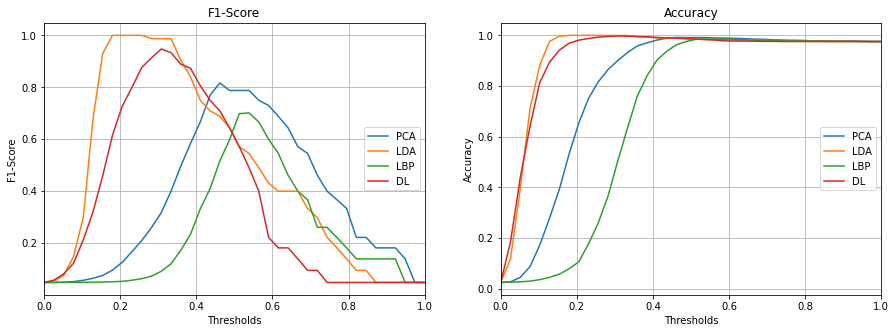

In [406]:
# Plot accuracy and F1-scores
thresh_at = np.linspace(0,1,n_classes_at)
acc_pca_at, f1_score_pca_at = calculate_acc(thresh_at,pca_genuines_at,pca_impostors_at)
acc_lda_at, f1_score_lda_at = calculate_acc(thresh_at,lda_genuines_at,lda_impostors_at)
acc_lbp_at, f1_score_lbp_at = calculate_acc(thresh_at,lbp_genuines_at,lbp_impostors_at)
acc_dl_at, f1_score_dl_at = calculate_acc(thresh_at,dl_genuines_at,dl_impostors_at)

fig = plt.figure(figsize=(15, 5))
# Plot F1-Scores
fig.add_subplot(1, 2, 1)
plt.plot(thresh_at,f1_score_pca_at,label='PCA');
plt.plot(thresh_at,f1_score_lda_at,label='LDA');
plt.plot(thresh_at,f1_score_lbp_at,label='LBP');
plt.plot(thresh_at,f1_score_dl_at,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("F1-Score", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("F1-Score")
# Plot accuracies
fig.add_subplot(1, 2, 2)
plt.plot(thresh_at,acc_pca_at,label='PCA');
plt.plot(thresh_at,acc_lda_at,label='LDA');
plt.plot(thresh_at,acc_lbp_at,label='LBP');
plt.plot(thresh_at,acc_dl_at,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("Accuracy", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("Accuracy");
plt.savefig("output_imgs/f1_accuracy_at.png")

In [407]:
# Optimal thresholds: 2 explained approaches
print("APPROACH 1: USING F1-SCORES")
optimal_threshold_f1score(f1_score_pca_at,thresh_at,"PCA")
optimal_threshold_f1score(f1_score_lda_at,thresh_at,"LDA")
optimal_threshold_f1score(f1_score_lbp_at,thresh_at,"LBP")
optimal_threshold_f1score(f1_score_dl_at,thresh_at,"DL")

fpr_pca_at, tpr_pca_at, thresh_pca_2_at = roc_curve(genuine_id_pca_at,scores_pca_at)
fpr_lda_at, tpr_lda_at, thresh_lda_2_at = roc_curve(genuine_id_lda_at,scores_lda_at)
fpr_lbp_at, tpr_lbp_at, thresh_lbp_2_at = roc_curve(genuine_id_lbp_at,scores_lbp_at)
fpr_dl_at, tpr_dl_at, thresh_dl_2_at = roc_curve(genuine_id_dl_at,scores_dl_at)

print("\nAPPROACH 2: USING G-MEAN AND ROC CURVES")
optimal_threshold_gmean(tpr_pca_at,fpr_pca_at,thresh_pca_2_at,"PCA")
optimal_threshold_gmean(tpr_lda_at,fpr_lda_at,thresh_lda_2_at,"LDA")
optimal_threshold_gmean(tpr_lbp_at,fpr_lbp_at,thresh_lbp_2_at,"LBP")
optimal_threshold_gmean(tpr_dl_at,fpr_dl_at,thresh_dl_2_at,"DL")

APPROACH 1: USING F1-SCORES
PCA: Optimal threshold 0.46154 - (max F1-score = 0.8169).
LDA: Optimal threshold 0.17949 - (max F1-score = 1.0).
LBP: Optimal threshold 0.53846 - (max F1-score = 0.7013).
DL: Optimal threshold 0.30769 - (max F1-score = 0.94737).

APPROACH 2: USING G-MEAN AND ROC CURVES
PCA Optimal threshold 0.328 - max G-Mean 0.928
	Optimal FPR: 0.069, Optimal TPR: 0.925
LDA Optimal threshold 0.277 - max G-Mean 1.0
	Optimal FPR: 0.0, Optimal TPR: 1.0
LBP Optimal threshold 0.422 - max G-Mean 0.947
	Optimal FPR: 0.079, Optimal TPR: 0.975
DL Optimal threshold 0.255 - max G-Mean 0.997
	Optimal FPR: 0.006, Optimal TPR: 1.0


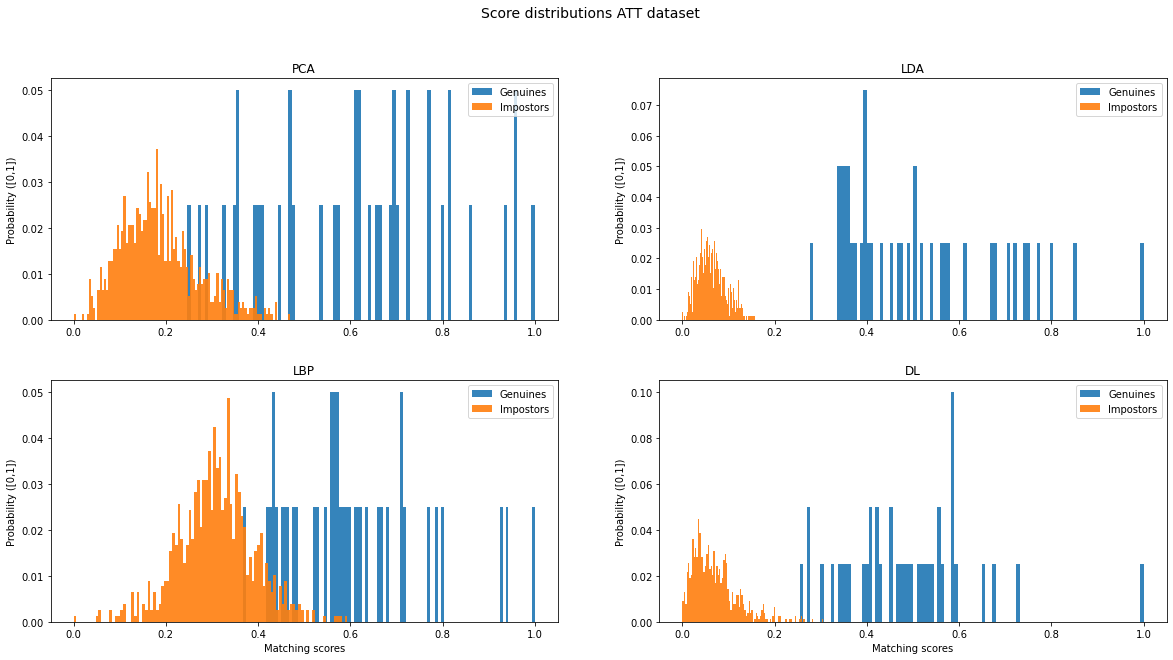

In [408]:
# SCORE DISTRIBUTIONS 
fig = plt.figure(figsize=(20, 10))
# PCA
fig.add_subplot(2, 2, 1)
plt.hist(pca_genuines_at, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(pca_genuines_at)) / len(pca_genuines_at));
plt.hist(pca_impostors_at, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(pca_impostors_at)) / len(pca_impostors_at));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("PCA")
plt.legend(loc='upper right');
  
# LDA
fig.add_subplot(2, 2, 2) 
plt.hist(lda_genuines_at, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(lda_genuines_at)) / len(lda_genuines_at));
plt.hist(lda_impostors_at, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lda_impostors_at)) / len(lda_impostors_at));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LDA")
plt.legend(loc='upper right');

# LBP
fig.add_subplot(2, 2, 3)
plt.hist(lbp_genuines_at, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(lbp_genuines_at)) / len(lbp_genuines_at));
plt.hist(lbp_impostors_at, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lbp_impostors_at)) / len(lbp_impostors_at));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LBP")
plt.legend(loc='upper right');
  
# DL
fig.add_subplot(2, 2, 4) 
plt.hist(dl_genuines_at, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(dl_genuines_at)) / len(dl_genuines_at));
plt.hist(dl_impostors_at, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(dl_impostors_at)) / len(dl_impostors_at));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("DL")
plt.legend(loc='upper right');
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Score distributions ATT dataset",fontsize=14);
plt.savefig("output_imgs/score_distributions_at.png")

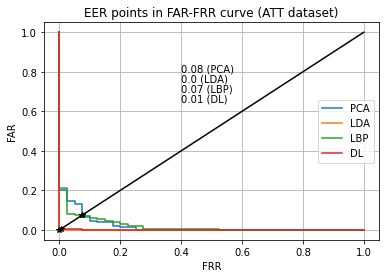

In [409]:
# FROM ASSIGNMENT 1: Retrieve FPR and TPR extracted before in ROC curve
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve.""" 
fpr_pca_at, tpr_pca_at, _ = roc_curve(genuine_id_pca_at,scores_pca_at)
fpr_lda_at, tpr_lda_at, _ = roc_curve(genuine_id_lda_at,scores_lda_at)
fpr_lbp_at, tpr_lbp_at, _ = roc_curve(genuine_id_lbp_at,scores_lbp_at)
fpr_dl_at, tpr_dl_at, _ = roc_curve(genuine_id_dl_at,scores_dl_at)
# EER computation #https://yangcha.github.io/EER-ROC/
eer_pca_at = brentq(lambda x : 1. - x - interp1d(fpr_pca_at, tpr_pca_at)(x), 0., 1.)
eer_lda_at = brentq(lambda x : 1. - x - interp1d(fpr_lda_at, tpr_lda_at)(x), 0., 1.)
eer_lbp_at = brentq(lambda x : 1. - x - interp1d(fpr_lbp_at, tpr_lbp_at)(x), 0., 1.)
eer_dl_at = brentq(lambda x : 1. - x - interp1d(fpr_dl_at, tpr_dl_at)(x), 0., 1.)

# Plot the equal error rate in FAR-FRR curve 
plt.plot(1-tpr_pca_at,fpr_pca_at, label="PCA");
plt.plot(1-tpr_lda_at,fpr_lda_at, label="LDA");
plt.plot(1-tpr_lbp_at,fpr_lbp_at, label="LBP");
plt.plot(1-tpr_dl_at,fpr_dl_at, label="DL");
plt.plot(fpr_pca_at,fpr_pca_at,color='black')
# EERs
plt.plot(eer_pca_at, eer_pca_at, 'k*')
plt.text(0.4,0.8,"{} (PCA)".format(round(eer_pca_at,2)))
plt.plot(eer_lda_at, eer_lda_at, 'k*')
plt.text(0.4,0.75,"{} (LDA)".format(round(eer_lda_at,2)))
plt.plot(eer_lbp_at, eer_lbp_at, 'k*')
plt.text(0.4,0.7,"{} (LBP)".format(round(eer_lbp_at,2)))
plt.plot(eer_dl_at, eer_dl_at, 'k*')
plt.text(0.4,0.65,"{} (DL)".format(round(eer_dl_at,2)))
plt.xlabel("FRR", size=10)
plt.ylabel("FAR", size=10)
plt.legend()
plt.title("EER points in FAR-FRR curve (ATT dataset)")
plt.grid()
plt.savefig("output_imgs/eer_far_frr_curve_at.png")

Area Under the PR-curve (PCA): 0.8329238397652833
Area Under the PR-curve (LDA): 1.0
Area Under the PR-curve (LBP): 0.7489428117587283
Area Under the PR-curve (DL): 0.9901857243180882


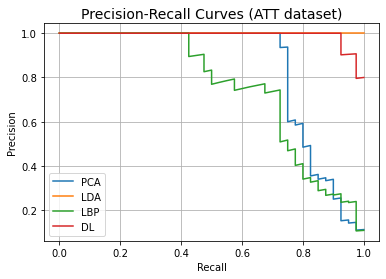

In [410]:
# FROM ASSIGNMENT 1
"""Calculate and plot the Precision-Recall curve for this system"""
precision_pca_at, recall_pca_at, _ = precision_recall_curve(genuine_id_pca_at,scores_pca_at)
precision_lda_at, recall_lda_at, _ = precision_recall_curve(genuine_id_lda_at,scores_lda_at)
precision_lbp_at, recall_lbp_at, _ = precision_recall_curve(genuine_id_lbp_at,scores_lbp_at)
precision_dl_at, recall_dl_at, _ = precision_recall_curve(genuine_id_dl_at,scores_dl_at)
auc_pr_pca_at = auc(recall_pca_at,precision_pca_at)
print("Area Under the PR-curve (PCA):",auc_pr_pca_at)
auc_pr_lda_at = auc(recall_lda_at,precision_lda_at)
print("Area Under the PR-curve (LDA):",auc_pr_lda_at)
auc_pr_lbp_at = auc(recall_lbp_at,precision_lbp_at)
print("Area Under the PR-curve (LBP):",auc_pr_lbp_at)
auc_pr_dl_at = auc(recall_dl_at,precision_dl_at)
print("Area Under the PR-curve (DL):",auc_pr_dl_at)
plt.plot(recall_pca_at,precision_pca_at,label='PCA');
plt.plot(recall_lda_at,precision_lda_at,label='LDA');
plt.plot(recall_lbp_at,precision_lbp_at,label='LBP');
plt.plot(recall_dl_at,precision_dl_at,label='DL');
plt.xlabel("Recall", size=10)
plt.ylabel("Precision", size=10)
plt.grid()
plt.legend()
plt.title("Precision-Recall Curves (ATT dataset)",fontsize=14);
plt.savefig("output_imgs/pr_curves_at.png")

Average precision score (PCA): 0.8336645886956757
Average precision score (LDA): 1.0
Average precision score (LBP): 0.7508335052444531
Average precision score (DL): 0.990293466223699
Rank-1 Recognition Rate (PCA) 1.0
Rank-1 Recognition Rate (LDA) 1.0
Rank-1 Recognition Rate (LBP) 0.975
Rank-1 Recognition Rate (DL) 1.0


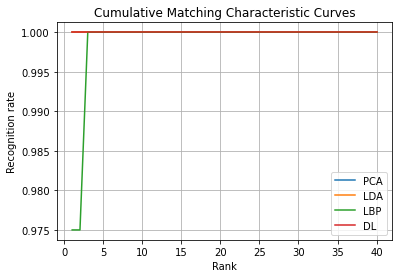

In [411]:
"""Calculate the average precision scores"""
avg_precision_pca_at = average_precision_score(genuine_id_pca_at,scores_pca_at)
print("Average precision score (PCA):",avg_precision_pca_at)
avg_precision_lda_at = average_precision_score(genuine_id_lda_at,scores_lda_at)
print("Average precision score (LDA):",avg_precision_lda_at)
avg_precision_lbp_at = average_precision_score(genuine_id_lbp_at,scores_lbp_at)
print("Average precision score (LBP):",avg_precision_lbp_at)
avg_precision_dl_at = average_precision_score(genuine_id_dl_at,scores_dl_at)
print("Average precision score (DL):",avg_precision_dl_at)

# CMC curves
ranks_at = list(range(1,n_classes_at+1))
recogn_rates_pca_at, rank_1_pca_at = cumulative_matching_characteristic(dist_matrix_pca_at)
recogn_rates_lda_at, rank_1_lda_at = cumulative_matching_characteristic(dist_matrix_lda_at)
recogn_rates_lbp_at, rank_1_lbp_at = cumulative_matching_characteristic(dist_matrix_lbp_at)
recogn_rates_dl_at, rank_1_dl_at = cumulative_matching_characteristic(dist_matrix_dl_at)
# Plot CMC curve
plt.plot(ranks_at, recogn_rates_pca_at, label = "PCA")
plt.plot(ranks_at, recogn_rates_lda_at, label = "LDA")
plt.plot(ranks_at, recogn_rates_lbp_at, label = "LBP")
plt.plot(ranks_at, recogn_rates_dl_at, label = "DL")
plt.xlabel('Rank')
plt.ylabel('Recognition rate')
plt.title('Cumulative Matching Characteristic Curves')
plt.legend()
plt.grid()
plt.savefig("output_imgs/cmc_curves_att.png")
print("Rank-1 Recognition Rate (PCA)",rank_1_pca_at)
print("Rank-1 Recognition Rate (LDA)",rank_1_lda_at)
print("Rank-1 Recognition Rate (LBP)",rank_1_lbp_at)
print("Rank-1 Recognition Rate (DL)",rank_1_dl_at)

## b) LFW dataset

Initially: 13233 images of shape (62, 47).
Initially: 5749 distinct labels.

SUBSAMPLED DATASET: only 20 distinct classes are going to be considered (750 samples in total)

After filtering 20 images per class...
Array of data (n_samples,n_features): (750, 2914)
Array of images (n_samples, shape): (750, 62, 47)
Array of correspondent labels (n_samples): (750,)
Images (after resizing) (n_samples, (shape)): (750, 47, 47)
Images (after resizing, 3d dim for DL Siamese) (n_samples, (shape)): (750, 47, 47, 1)


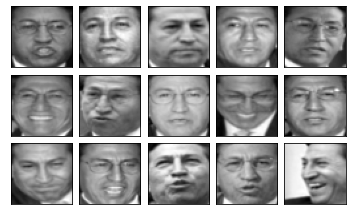

In [412]:
from operator import countOf
# Retrieve images and labels. Dataset exploration
# Restructure the images in array images and see images and their labels shapes
print("Initially: {} images of shape {}.".format(fetch_faces["images"].shape[0],fetch_faces["images"].shape[1:]))
lfw_classes, imgs_per_label = np.unique(fetch_faces["target"],return_counts=True)
print("Initially: {} distinct labels.".format(len(lfw_classes)))

# Filter dataset as 13233 images of 5749 classes is a lot
# Take only classes with >20 and <200 samples
our_labels = list()
n_samples = 0
for i,lab in enumerate(lfw_classes):
    if imgs_per_label[i] > 30 and imgs_per_label[i] < 50:
        #print("Label {} -> {} images.".format(lab,imgs_per_label[i]))
        our_labels.append(lab)
        n_samples = n_samples + v[i]
        
n_classes_lfw = len(our_labels)
print("\nSUBSAMPLED DATASET: only {} distinct classes are going to be considered ({} samples in total)"
      .format(n_classes_lfw,n_samples))

lfw_imgs = list()
lfw_data = list()
lfw_labels = list()

#for i, data in enumerate(fetch_faces.data):
#    # If a sample has a gt label in our considered labels, we add to our new filtered dataset
#    if fetch_faces.target[i] in our_labels:
#        if countOf(lfw_labels, fetch_faces.target[i]) < 20:
#            lfw_data.append(fetch_faces.data[i])
#            lfw_imgs.append(fetch_faces.images[i])
#            lfw_labels.append(fetch_faces.target[i])

for l,label in enumerate(our_labels):  
    for i, data in enumerate(fetch_faces.data):
        # If a sample has a gt label in our considered labels, we add to our new filtered dataset
        if fetch_faces.target[i] == label:
            if countOf(lfw_labels, fetch_faces.target[i]) < 20:
                lfw_data.append(fetch_faces.data[i])
                lfw_imgs.append(fetch_faces.images[i])
                #lfw_labels.append(fetch_faces.target[i])
                lfw_labels.append(l)
        
lfw_imgs = np.array(lfw_imgs)
lfw_data = np.array(lfw_data)
lfw_labels = np.array(lfw_labels) 
print("\nAfter filtering 20 images per class...")
print("Array of data (n_samples,n_features):",lfw_data.shape)
print("Array of images (n_samples, shape):",lfw_imgs.shape)
print("Array of correspondent labels (n_samples):",lfw_labels.shape)
lfw_images,lfw_images_full = list(), list()
for img in lfw_imgs:
    img = cv2.resize(img,face_size) # resize to 47x47 (min_size is 47)
    lfw_images.append(img)
    img = np.resize(img,face_size +(1,)) # To fit the siamese network input
    lfw_images_full.append(img)
lfw_images = np.array(lfw_images)
lfw_images_full = np.array(lfw_images_full)
print("Images (after resizing) (n_samples, (shape)):",lfw_images.shape)
print("Images (after resizing, 3d dim for DL Siamese) (n_samples, (shape)):",lfw_images_full.shape)

# See some images
fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111,nrows_ncols=(3, 5), axes_pad=0.1)
for ax, im in zip(grid, lfw_images_full):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [413]:
# For my info
print("DATA:",lfw_data.shape) 
print("LABELS:",lfw_labels.shape)
print("IMAGES:",lfw_images.shape) 
print("FULL IMAGES:",lfw_images_full.shape)

DATA: (750, 2914)
LABELS: (750,)
IMAGES: (750, 47, 47)
FULL IMAGES: (750, 47, 47, 1)


In [414]:
# Retrieve all embeddeds to construct distance matrixes
    # PCA
num_components = 35
n_components = min(num_components, min(lfw_data.shape[0],lfw_data.shape[1]))
desc = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(lfw_data)
X_pca_lfw = desc.transform(lfw_data)
embedded_pca_lfw = X_pca_lfw
print("Embedded PCA shape ({} comps): {}".format(n_components,embedded_pca_lfw.shape)) # (n_images x n_components)

    # LDA
num_components = min(num_components, min(n_classes_lfw - 1, lfw_data.shape[1]))
desc = LinearDiscriminantAnalysis(n_components=num_components).fit(lfw_data, lfw_labels)
X_lda_lfw = desc.fit_transform(lfw_data, lfw_labels)
embedded_lda_lfw = X_lda_lfw
print("Embedded LDA shape:",embedded_lda_lfw.shape)

    # LBP (same params)
desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_lbp_lfw = desc.describe_list(lfw_images)
print("Embedded LBP shape:",embedded_lbp_lfw.shape)

Embedded PCA shape (35 comps): (750, 35)
Embedded LDA shape: (750, 19)
Embedded LBP shape: (750, 490)


In [415]:
#DL: Siamese networks
imshape_lfw = lfw_images_full.shape[1:] #(64,64,1)
# Create model and split data
encoder_lfw, model_lfw = siamese.create_siamese_model(imshape_lfw) 
x_train_lfw, x_test_lfw, y_train_lfw, y_test_lfw = holdout_split(*siamese.get_siamese_paired_data(lfw_images_full, lfw_labels))
# Learning process configuration
model_lfw.compile(loss=siamese.contrastive_loss, optimizer=Adam(), metrics = [siamese.accuracy],run_eagerly=True)
# Load or train the model
epochs = 10
if 'model_lfw_faces.h5' in files:
        model_lfw = keras.models.load_model('model_lfw_faces.h5', compile=False) #if inference/no optimization nor training
else:
        model_lfw.fit([x_train_lfw[:, 0], x_train_lfw[:, 1]], y_train_lfw, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
        model_lfw.save("model_lfw_faces.h5")
        print("Model LFW saved.")
    
# Prediction and embedded_dl extraction    
test_scores_lfw = model_lfw.predict([x_test_lfw[:, 0], x_test_lfw[:, 1]])
test_acc_lfw = accuracy_score(y_test_lfw, test_scores_lfw > 0.5)
print("Accuracy on the test set: {}".format(test_acc_lfw)) #Accuracy on the test set: 0.79
embedded_dl_lfw = encoder_lfw(lfw_images_full.astype(np.float32)).numpy()


Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 - 63s - loss: 0.1282 - accuracy: 0.5961 - val_loss: 0.1071 - val_accuracy: 0.6594
Epoch 2/10
1280/1280 - 56s - loss: 0.0978 - accuracy: 0.6984 - val_loss: 0.0973 - val_accuracy: 0.7094
Epoch 3/10
1280/1280 - 58s - loss: 0.0825 - accuracy: 0.7648 - val_loss: 0.0901 - val_accuracy: 0.7500
Epoch 4/10
1280/1280 - 69s - loss: 0.0716 - accuracy: 0.8250 - val_loss: 0.0808 - val_accuracy: 0.7688
Epoch 5/10
1280/1280 - 59s - loss: 0.0629 - accuracy: 0.8578 - val_loss: 0.0771 - val_accuracy: 0.7812
Epoch 6/10
1280/1280 - 70s - loss: 0.0553 - accuracy: 0.8867 - val_loss: 0.0791 - val_accuracy: 0.7719
Epoch 7/10
1280/1280 - 60s - loss: 0.0521 - accuracy: 0.9078 - val_loss: 0.0780 - val_accuracy: 0.7781
Epoch 8/10
1280/1280 - 57s - loss: 0.0454 - accuracy: 0.9281 - val_loss: 0.0821 - val_accuracy: 0.7656
Epoch 9/10
1280/1280 - 57s - loss: 0.0403 - accuracy: 0.9445 - val_loss: 0.0724 - val_accuracy: 0.8188
Epoch 10/10
1280/1280 - 63

In [421]:
print(embedded_pca_lfw.shape)
print(embedded_lda_lfw.shape)
print(embedded_lbp_lfw.shape)
print(embedded_dl_lfw.shape)

(750, 35)
(750, 19)
(750, 490)
(750, 128)


In [416]:
# Construct distance matrixes
dist_matrix_pca_lfw = pairwise_distances(embedded_pca_lfw,euclidean,lfw_labels)
dist_matrix_lda_lfw = pairwise_distances(embedded_lda_lfw,euclidean,lfw_labels)
dist_matrix_lbp_lfw = pairwise_distances(embedded_lbp_lfw,CHI2,lfw_labels)
dist_matrix_dl_lfw = pairwise_distances(embedded_dl_lfw,euclidean,lfw_labels)

In [417]:
# Convert the similarities between classes from similarities (1/distances) to scores
genuine_id_pca_lfw, scores_pca_lfw = sim2scores(dist_matrix_pca_lfw)
genuine_id_lda_lfw, scores_lda_lfw = sim2scores(dist_matrix_lda_lfw)
genuine_id_lbp_lfw, scores_lbp_lfw = sim2scores(dist_matrix_lbp_lfw)
genuine_id_dl_lfw, scores_dl_lfw = sim2scores(dist_matrix_dl_lfw)
pca_genuines_lfw,pca_impostors_lfw = distr_scores(genuine_id_pca_lfw,scores_pca_lfw) #PCA
lda_genuines_lfw, lda_impostors_lfw = distr_scores(genuine_id_lda_lfw,scores_lda_lfw) #LDA
lbp_genuines_lfw,lbp_impostors_lfw = distr_scores(genuine_id_lbp_lfw,scores_lbp_lfw) #LBP
dl_genuines_lfw,dl_impostors_lfw = distr_scores(genuine_id_dl_lfw,scores_dl_lfw) #DL

# Check all the same (20 genuine scores and 380 impostors)
assert len(pca_genuines_lfw) == len(lda_genuines_lfw) == len(lbp_genuines_lfw) == len(dl_genuines_lfw), "Error: all techniques should have the same number of genuine scores."
assert len(pca_impostors_lfw) == len(lda_impostors_lfw) == len(lbp_impostors_lfw) == len(dl_impostors_lfw), "Error: all techniques should have the same number of impostor scores."
print("For any technique:",len(pca_genuines_lfw),"genuine scores and",len(pca_impostors_lfw),"impostor scores.")

For any technique: 20 genuine scores and 380 impostor scores.


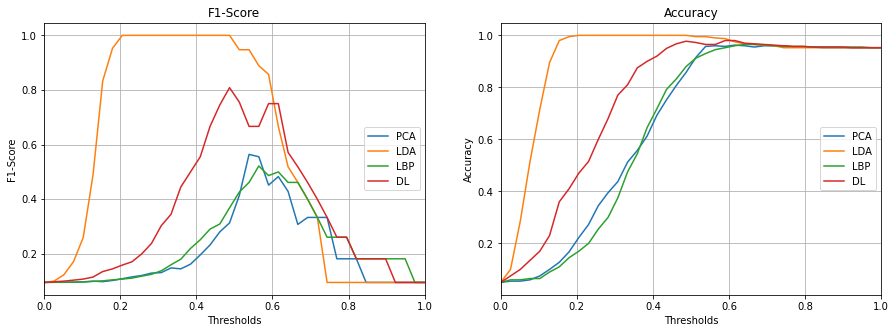

In [423]:
# Plot accuracy and F1-scores
thresh_lfw = np.linspace(0,1,n_classes_at)
acc_pca_lfw, f1_score_pca_lfw = calculate_acc(thresh_lfw,pca_genuines_lfw,pca_impostors_lfw)
acc_lda_lfw, f1_score_lda_lfw = calculate_acc(thresh_lfw,lda_genuines_lfw,lda_impostors_lfw)
acc_lbp_lfw, f1_score_lbp_lfw = calculate_acc(thresh_lfw,lbp_genuines_lfw,lbp_impostors_lfw)
acc_dl_lfw, f1_score_dl_lfw = calculate_acc(thresh_lfw,dl_genuines_lfw,dl_impostors_lfw)

fig = plt.figure(figsize=(15, 5))
# Plot F1-Scores
fig.add_subplot(1, 2, 1)
plt.plot(thresh_lfw,f1_score_pca_lfw,label='PCA');
plt.plot(thresh_lfw,f1_score_lda_lfw,label='LDA');
plt.plot(thresh_lfw,f1_score_lbp_lfw,label='LBP');
plt.plot(thresh_lfw,f1_score_dl_lfw,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("F1-Score", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("F1-Score")
# Plot accuracies
fig.add_subplot(1, 2, 2)
plt.plot(thresh_lfw,acc_pca_lfw,label='PCA');
plt.plot(thresh_lfw,acc_lda_lfw,label='LDA');
plt.plot(thresh_lfw,acc_lbp_lfw,label='LBP');
plt.plot(thresh_lfw,acc_dl_lfw,label='DL');
plt.xlabel("Thresholds", size=10)
plt.ylabel("Accuracy", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("Accuracy");
plt.savefig("output_imgs/f1_accuracy_lfw.png")

In [424]:
# Optimal thresholds: 2 explained approaches
print("APPROACH 1: USING F1-SCORES")
optimal_threshold_f1score(f1_score_pca_lfw,thresh_lfw,"PCA")
optimal_threshold_f1score(f1_score_lda_lfw,thresh_lfw,"LDA")
optimal_threshold_f1score(f1_score_lbp_lfw,thresh_lfw,"LBP")
optimal_threshold_f1score(f1_score_dl_lfw,thresh_lfw,"DL")

fpr_pca_lfw, tpr_pca_lfw, thresh_pca_2_lfw = roc_curve(genuine_id_pca_lfw,scores_pca_lfw)
fpr_lda_lfw, tpr_lda_lfw, thresh_lda_2_lfw = roc_curve(genuine_id_lda_lfw,scores_lda_lfw)
fpr_lbp_lfw, tpr_lbp_lfw, thresh_lbp_2_lfw = roc_curve(genuine_id_lbp_lfw,scores_lbp_lfw)
fpr_dl_lfw, tpr_dl_lfw, thresh_dl_2_lfw = roc_curve(genuine_id_dl_lfw,scores_dl_lfw)

print("\nAPPROACH 2: USING G-MEAN AND ROC CURVES")
optimal_threshold_gmean(tpr_pca_lfw,fpr_pca_lfw,thresh_pca_2_lfw,"PCA")
optimal_threshold_gmean(tpr_lda_lfw,fpr_lda_lfw,thresh_lda_2_lfw,"LDA")
optimal_threshold_gmean(tpr_lbp_lfw,fpr_lbp_lfw,thresh_lbp_2_lfw,"LBP")
optimal_threshold_gmean(tpr_dl_lfw,fpr_dl_lfw,thresh_dl_2_lfw,"DL")

APPROACH 1: USING F1-SCORES
PCA: Optimal threshold 0.53846 - (max F1-score = 0.5641).
LDA: Optimal threshold 0.20513 - (max F1-score = 1.0).
LBP: Optimal threshold 0.5641 - (max F1-score = 0.52174).
DL: Optimal threshold 0.48718 - (max F1-score = 0.80851).

APPROACH 2: USING G-MEAN AND ROC CURVES
PCA Optimal threshold 0.468 - max G-Mean 0.785
	Optimal FPR: 0.179, Optimal TPR: 0.75
LDA Optimal threshold 0.493 - max G-Mean 1.0
	Optimal FPR: 0.0, Optimal TPR: 1.0
LBP Optimal threshold 0.431 - max G-Mean 0.863
	Optimal FPR: 0.216, Optimal TPR: 0.95
DL Optimal threshold 0.455 - max G-Mean 0.984
	Optimal FPR: 0.032, Optimal TPR: 1.0


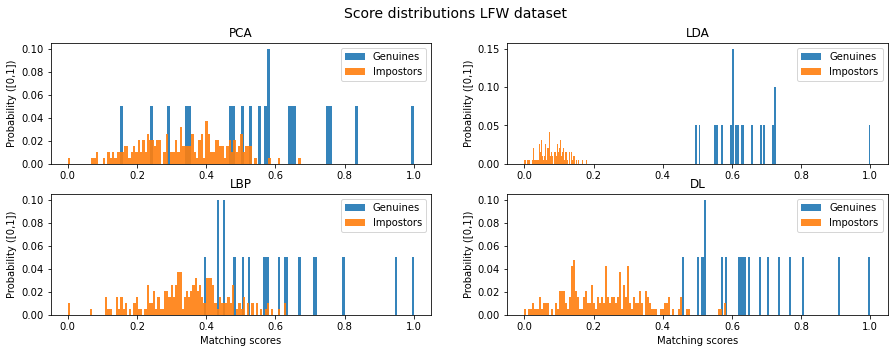

In [425]:
# SCORE DISTRIBUTIONS 
fig = plt.figure(figsize=(15,5))
# PCA
fig.add_subplot(2, 2, 1)
plt.hist(pca_genuines_lfw, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(pca_genuines_lfw)) / len(pca_genuines_lfw));
plt.hist(pca_impostors_lfw, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(pca_impostors_lfw)) / len(pca_impostors_lfw));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("PCA")
plt.legend(loc='upper right');
  
# LDA
fig.add_subplot(2, 2, 2) 
plt.hist(lda_genuines_lfw, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(lda_genuines_lfw)) / len(lda_genuines_lfw));
plt.hist(lda_impostors_lfw, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lda_impostors_lfw)) / len(lda_impostors_lfw));
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LDA")
plt.legend(loc='upper right');

# LBP
fig.add_subplot(2, 2, 3)
plt.hist(lbp_genuines_lfw, bins=100, alpha=0.9, label="Genuines",weights=np.ones(len(lbp_genuines_lfw)) / len(lbp_genuines_lfw));
plt.hist(lbp_impostors_lfw, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(lbp_impostors_lfw)) / len(lbp_impostors_lfw));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("LBP")
plt.legend(loc='upper right');
  
# DL
fig.add_subplot(2, 2, 4) 
plt.hist(dl_genuines_lfw, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(dl_genuines_lfw)) / len(dl_genuines_lfw));
plt.hist(dl_impostors_lfw, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(dl_impostors_lfw)) / len(dl_impostors_lfw));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("DL")
plt.legend(loc='upper right');
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Score distributions LFW dataset",fontsize=14);
plt.savefig("output_imgs/score_distributions_lfw.png")

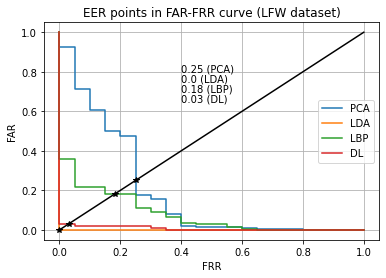

In [426]:
# FROM ASSIGNMENT 1: Retrieve FPR and TPR extracted before in ROC curve
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve.""" 
fpr_pca_lfw, tpr_pca_lfw, _ = roc_curve(genuine_id_pca_lfw,scores_pca_lfw)
fpr_lda_lfw, tpr_lda_lfw, _ = roc_curve(genuine_id_lda_lfw,scores_lda_lfw)
fpr_lbp_lfw, tpr_lbp_lfw, _ = roc_curve(genuine_id_lbp_lfw,scores_lbp_lfw)
fpr_dl_lfw, tpr_dl_lfw, _ = roc_curve(genuine_id_dl_lfw,scores_dl_lfw)
# EER computation #https://yangcha.github.io/EER-ROC/
eer_pca_lfw = brentq(lambda x : 1. - x - interp1d(fpr_pca_lfw, tpr_pca_lfw)(x), 0., 1.)
eer_lda_lfw = brentq(lambda x : 1. - x - interp1d(fpr_lda_lfw, tpr_lda_lfw)(x), 0., 1.)
eer_lbp_lfw = brentq(lambda x : 1. - x - interp1d(fpr_lbp_lfw, tpr_lbp_lfw)(x), 0., 1.)
eer_dl_lfw = brentq(lambda x : 1. - x - interp1d(fpr_dl_lfw, tpr_dl_lfw)(x), 0., 1.)

# Plot the equal error rate in FAR-FRR curve 
plt.plot(1-tpr_pca_lfw,fpr_pca_lfw, label="PCA");
plt.plot(1-tpr_lda_lfw,fpr_lda_lfw, label="LDA");
plt.plot(1-tpr_lbp_lfw,fpr_lbp_lfw, label="LBP");
plt.plot(1-tpr_dl_lfw,fpr_dl_lfw,label="DL");
plt.plot(fpr_pca_lfw,fpr_pca_lfw,color='black')
# EERs
plt.plot(eer_pca_lfw, eer_pca_lfw, 'k*')
plt.text(0.4,0.8,"{} (PCA)".format(round(eer_pca_lfw,2)))
plt.plot(eer_lda_lfw, eer_lda_lfw, 'k*')
plt.text(0.4,0.75,"{} (LDA)".format(round(eer_lda_lfw,2)))
plt.plot(eer_lbp_lfw, eer_lbp_lfw, 'k*')
plt.text(0.4,0.7,"{} (LBP)".format(round(eer_lbp_lfw,2)))
plt.plot(eer_dl_lfw, eer_dl_lfw, 'k*')
plt.text(0.4,0.65,"{} (DL)".format(round(eer_dl_lfw,2)))
plt.xlabel("FRR", size=10)
plt.ylabel("FAR", size=10)
plt.legend()
plt.title("EER points in FAR-FRR curve (LFW dataset)")
plt.grid()
plt.savefig("output_imgs/eer_far_frr_curve_lfw.png")

Area Under the PR-curve (PCA): 0.513080622568615
Area Under the PR-curve (LDA): 1.0000000000000002
Area Under the PR-curve (LBP): 0.5736840169011967
Area Under the PR-curve (DL): 0.8875687692510047


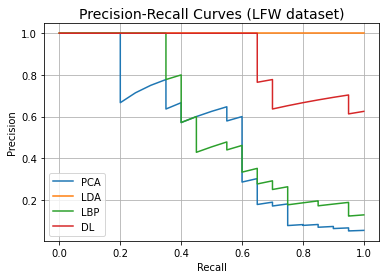

In [427]:
# FROM ASSIGNMENT 1
"""Calculate and plot the Precision-Recall curve for this system"""
precision_pca_lfw, recall_pca_lfw, _ = precision_recall_curve(genuine_id_pca_lfw,scores_pca_lfw)
precision_lda_lfw, recall_lda_lfw, _ = precision_recall_curve(genuine_id_lda_lfw,scores_lda_lfw)
precision_lbp_lfw, recall_lbp_lfw, _ = precision_recall_curve(genuine_id_lbp_lfw,scores_lbp_lfw)
precision_dl_lfw, recall_dl_lfw, _ = precision_recall_curve(genuine_id_dl_lfw,scores_dl_lfw)
auc_pr_pca_lfw = auc(recall_pca_lfw,precision_pca_lfw)
print("Area Under the PR-curve (PCA):",auc_pr_pca_lfw)
auc_pr_lda_lfw = auc(recall_lda_lfw,precision_lda_lfw)
print("Area Under the PR-curve (LDA):",auc_pr_lda_lfw)
auc_pr_lbp_lfw = auc(recall_lbp_lfw,precision_lbp_lfw)
print("Area Under the PR-curve (LBP):",auc_pr_lbp_lfw)
auc_pr_dl_lfw = auc(recall_dl_lfw,precision_dl_lfw)
print("Area Under the PR-curve (DL):",auc_pr_dl_lfw)
plt.plot(recall_pca_lfw,precision_pca_lfw,label='PCA');
plt.plot(recall_lda_lfw,precision_lda_lfw,label='LDA');
plt.plot(recall_lbp_lfw,precision_lbp_lfw,label='LBP');
plt.plot(recall_dl_lfw,precision_dl_lfw,label='DL');
plt.xlabel("Recall", size=10)
plt.ylabel("Precision", size=10)
plt.grid()
plt.legend()
plt.title("Precision-Recall Curves (LFW dataset)",fontsize=14);
plt.savefig("output_imgs/pr_curves_lfw.png")

Average precision score (PCA): 0.5204436465997259
Average precision score (LDA): 1.0000000000000002
Average precision score (LBP): 0.5789146724484395
Average precision score (DL): 0.889881487674966
Rank-1 Recognition Rate (PCA) 0.75
Rank-1 Recognition Rate (LDA) 1.0
Rank-1 Recognition Rate (LBP) 0.8
Rank-1 Recognition Rate (DL) 0.85


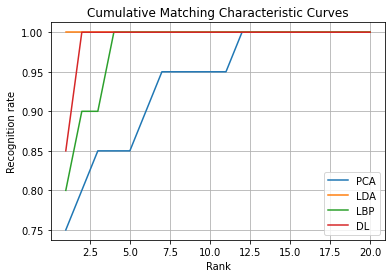

In [428]:
"""Calculate the average precision scores"""
avg_precision_pca_lfw = average_precision_score(genuine_id_pca_lfw,scores_pca_lfw)
print("Average precision score (PCA):",avg_precision_pca_lfw)
avg_precision_lda_lfw = average_precision_score(genuine_id_lda_lfw,scores_lda_lfw)
print("Average precision score (LDA):",avg_precision_lda_lfw)
avg_precision_lbp_lfw = average_precision_score(genuine_id_lbp_lfw,scores_lbp_lfw)
print("Average precision score (LBP):",avg_precision_lbp_lfw)
avg_precision_dl_lfw = average_precision_score(genuine_id_dl_lfw,scores_dl_lfw)
print("Average precision score (DL):",avg_precision_dl_lfw)

# CMC curves
ranks_lfw = list(range(1,n_classes_lfw+1))
recogn_rates_pca_lfw, rank_1_pca_lfw = cumulative_matching_characteristic(dist_matrix_pca_lfw)
recogn_rates_lda_lfw, rank_1_lda_lfw = cumulative_matching_characteristic(dist_matrix_lda_lfw)
recogn_rates_lbp_lfw, rank_1_lbp_lfw = cumulative_matching_characteristic(dist_matrix_lbp_lfw)
recogn_rates_dl_lfw, rank_1_dl_lfw = cumulative_matching_characteristic(dist_matrix_dl_lfw)
# Plot CMC curve
plt.plot(ranks_lfw, recogn_rates_pca_lfw, label = "PCA")
plt.plot(ranks_lfw, recogn_rates_lda_lfw, label = "LDA")
plt.plot(ranks_lfw, recogn_rates_lbp_lfw, label = "LBP")
plt.plot(ranks_lfw, recogn_rates_dl_lfw, label = "DL")
plt.xlabel('Rank')
plt.ylabel('Recognition rate')
plt.title('Cumulative Matching Characteristic Curves')
plt.legend()
plt.grid()
plt.savefig("output_imgs/cmc_curves_lfw.png")
print("Rank-1 Recognition Rate (PCA)",rank_1_pca_lfw)
print("Rank-1 Recognition Rate (LDA)",rank_1_lda_lfw)
print("Rank-1 Recognition Rate (LBP)",rank_1_lbp_lfw)
print("Rank-1 Recognition Rate (DL)",rank_1_dl_lfw)

# ------------------------------------------

# Exercise 5.
### Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. 

In [75]:
# Download or load the dataset (Labeled Faces in the Wild (LFW) people dataset (classification))
try:
    with open("fetch_faces.pkl","rb") as n:
        fetch_faces = pickle.load(n)
        print("Dataset fetchLFW loaded.")
except:
    fetch_faces = fetch_lfw_people(resize=0.5, color=False)

    with open("fetch_faces.pkl",'wb') as n:
        pickle.dump(fetch_faces,n)
        print("Dataset fetchLFW saved.")

Dataset fetchLFW loaded.


In [76]:
# Restructure the images in array images and see images and their labels shapes
lfw_images_ft = []
for img in fetch_faces["images"]:
    img = cv2.resize(img,face_size)
    # To fit the siamese network input
    img = np.resize(img,face_size +(1,))
    lfw_images_ft.append(img)    
lfw_images_ft = np.array(lfw_images_ft)
print("Images (n_samples, dims):",lfw_images_ft.shape)
lfw_labels_ft = fetch_faces["target"]
print("Labels:",lfw_labels_ft.shape)
#plt.imshow(images[36])

Images (n_samples, dims): (13233, 47, 47, 1)
Labels: (13233,)


In [78]:
# Create model
imshape = (47,47,1)
encoder_siam, model_siam = siamese.create_siamese_model(imshape)
model_siam.compile(
        loss=siamese.contrastive_loss, 
        optimizer=Adam(), 
        metrics = [siamese.accuracy],
        run_eagerly=True)

# Holdout split...
x_train_siam, x_test_siam, y_train_siam, y_test_siam = holdout_split(*siamese.get_siamese_paired_data(lfw_images_ft, lfw_labels_ft))

epochs = 10
if 'model_siamese.h5' in files:
    model_siam = keras.models.load_model('model_siamese.h5', compile=False) #if inference/no optimization nor training
    print("model_siamese loaded from directory.")
else:
    # Train the model in this LFW larger dataset with a few epochs
    # Here general feature extraction is transferred
    model_siam.fit([x_train_siam[:, 0], x_train_siam[:, 1]], y_train_siam, 
                  validation_split=0.2,
                  batch_size=32, verbose=2, epochs=epochs)
    model_siam.save('model_siamese.h5')
    print("Our model trained in LFW dataset saved.")

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 - 58s - loss: 0.0672 - accuracy: 0.8372 - val_loss: 0.0473 - val_accuracy: 0.9010
Epoch 2/10
1200/1200 - 53s - loss: 0.0344 - accuracy: 0.9178 - val_loss: 0.0489 - val_accuracy: 0.9010
Epoch 3/10
1200/1200 - 52s - loss: 0.0250 - accuracy: 0.9400 - val_loss: 0.0490 - val_accuracy: 0.9104
Epoch 4/10
1200/1200 - 51s - loss: 0.0186 - accuracy: 0.9498 - val_loss: 0.0464 - val_accuracy: 0.9042
Epoch 5/10
1200/1200 - 51s - loss: 0.0122 - accuracy: 0.9720 - val_loss: 0.0500 - val_accuracy: 0.9010
Epoch 6/10
1200/1200 - 51s - loss: 0.0088 - accuracy: 0.9877 - val_loss: 0.0537 - val_accuracy: 0.9010
Epoch 7/10
1200/1200 - 51s - loss: 0.0062 - accuracy: 0.9967 - val_loss: 0.0565 - val_accuracy: 0.9010
Epoch 8/10
1200/1200 - 53s - loss: 0.0041 - accuracy: 0.9975 - val_loss: 0.0563 - val_accuracy: 0.9042
Epoch 9/10
1200/1200 - 59s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0536 - val_accuracy: 0.9010
Epoch 10/10
1200/1200 - 51

In [79]:
print("General architecture of our new siamese network:\n")
[print("\t",i,"\n") for i in model_siam.layers];

General architecture of our new siamese network:







In [80]:
# For comparison with the given original network: see trainable/non-trainable params
print(model.layers[2].summary())

for layer in model_siam.layers[2].layers[:4]:
    #print(layer)
    layer.trainable = False
print("\nOur new Siamese model:\n")    
# Check if trainable/non-trainable params have changed
model_siam.layers[2].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 45, 45, 128)       1280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
Total params: 894,400
Trainable params: 894,400
Non-trainable params: 0
________________________________________________

In [81]:
# Configure new learning process
model_siam.compile(
        loss=siamese.contrastive_loss, 
        optimizer=Adam(), 
        metrics = [siamese.accuracy],
        run_eagerly=True)

epochs = 20
# Hold out split: now, our images and labels are used (CALTECH dataset of the assignment)
x_train_our, x_test_our, y_train_our, y_test_our = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
  
if 'model_siamese_improved.h5' in files:
    model_siam = keras.models.load_model('model_siamese_improved.h5', compile=False) #if inference/no optimization nor training
    print("model_siamese_improved loaded.")
else:
    model_siam.fit([x_train_our[:, 0], x_train_our[:, 1]], y_train_our, 
              validation_split=0.2,
              batch_size=16, verbose=2, epochs=epochs);


Train on 1200 samples, validate on 300 samples
Epoch 1/20
1200/1200 - 57s - loss: 0.0591 - accuracy: 0.8775 - val_loss: 0.0347 - val_accuracy: 0.9529
Epoch 2/20
1200/1200 - 59s - loss: 0.0239 - accuracy: 0.9792 - val_loss: 0.0238 - val_accuracy: 0.9836
Epoch 3/20
1200/1200 - 57s - loss: 0.0162 - accuracy: 0.9917 - val_loss: 0.0195 - val_accuracy: 0.9868
Epoch 4/20
1200/1200 - 57s - loss: 0.0122 - accuracy: 0.9967 - val_loss: 0.0179 - val_accuracy: 0.9825
Epoch 5/20
1200/1200 - 58s - loss: 0.0088 - accuracy: 0.9992 - val_loss: 0.0141 - val_accuracy: 0.9857
Epoch 6/20
1200/1200 - 57s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9901
Epoch 7/20
1200/1200 - 57s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9901
Epoch 8/20
1200/1200 - 57s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9901
Epoch 9/20
1200/1200 - 57s - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0104 - val_accuracy: 0.9934
Epoch 10/20
1200/1200 - 60

In [82]:
test_scores = model_siam.predict([x_test_our[:, 0], x_test_our[:, 1]])
test_acc_siam = accuracy_score(y_test_our, test_scores > 0.5) # compare with real labels
print("Accuracy on the test set: {}".format(test_acc_siam))

if test_acc_siam > test_acc:
    print("The fine-tuned model has improved the test accuracy of the original Siamese network!!! {} vs {}"
          .format(test_acc_siam,test_acc))
    model_siam.save('model_siamese_improved.h5')
    
embedded_dl_siam = encoder_siam(faces.images.astype(np.float32)).numpy()

Accuracy on the test set: 0.996
The fine-tuned model has improved the test accuracy of the original Siamese network!!! 0.996 vs 0.994


###### Now, some performance comparisons...

In [83]:
dist_matrix_dl_siam = pairwise_distances(embedded_dl_siam,euclidean,faces.target)

genuine_id_dl_siam, scores_dl_siam = sim2scores(dist_matrix_dl_siam)

dl_genuines_siam,dl_impostors_siam = distr_scores(genuine_id_dl_siam,scores_dl_siam) 

# Check all the same (20 genuine scores and 380 impostors)
print("For any technique:",len(dl_genuines_siam),"genuine scores and",len(dl_impostors_siam),"impostor scores.")

For any technique: 26 genuine scores and 650 impostor scores.


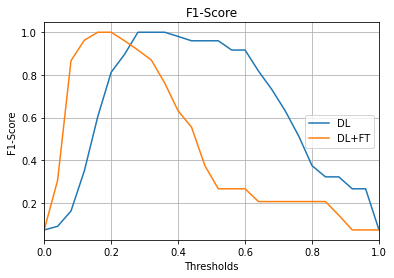

In [88]:
# Compute new accuracies and F1scores
acc_dl_siam, f1_score_dl_siam = calculate_acc(thresh,dl_genuines_siam,dl_impostors_siam)
#Plot
plt.plot(thresh,f1_score_dl,label='DL');
plt.plot(thresh,f1_score_dl_siam,label='DL+FT');
plt.legend();
plt.xlabel("Thresholds", size=10)
plt.ylabel("F1-Score", size=10)
plt.xlim([0,1])
plt.legend(loc='center right')
plt.grid()
plt.title("F1-Score");

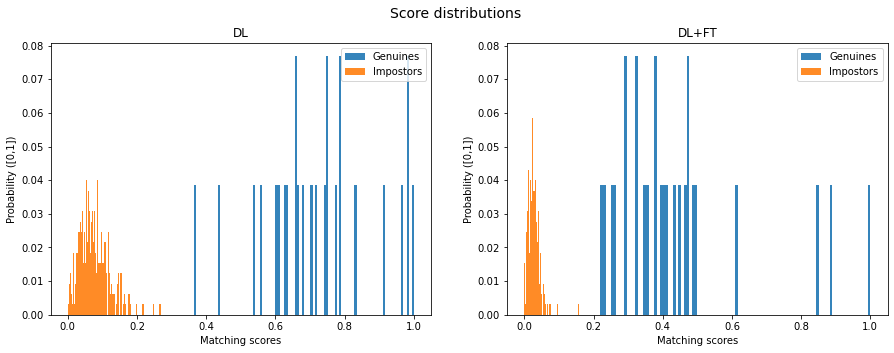

In [92]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(1, 2, 1) 
plt.hist(dl_genuines, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(dl_genuines)) / len(dl_genuines));
plt.hist(dl_impostors, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(dl_impostors)) / len(dl_impostors));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("DL")
plt.legend(loc='upper right');

fig.add_subplot(1, 2, 2) 
plt.hist(dl_genuines_siam, bins=100, alpha=0.9, label="Genuines", weights=np.ones(len(dl_genuines_siam)) / len(dl_genuines_siam));
plt.hist(dl_impostors_siam, bins=100, alpha=0.9, label="Impostors", weights=np.ones(len(dl_impostors_siam)) / len(dl_impostors_siam));
plt.xlabel("Matching scores", size=10)
plt.ylabel("Probability ([0,1])", size=10)
plt.title("DL+FT")
plt.legend(loc='upper right');
plt.subplots_adjust(hspace=0.25)
fig.suptitle("Score distributions",fontsize=14);


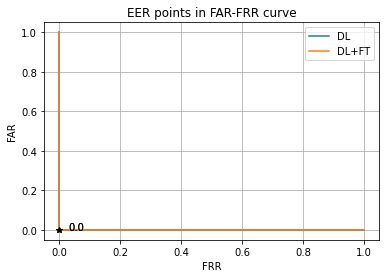

In [95]:
# Compute ROC and FPR, TPR
fpr_dl_siam, tpr_dl_siam, _ = roc_curve(genuine_id_dl_siam,scores_dl_siam)
# EER computation #https://yangcha.github.io/EER-ROC/
eer_dl_siam = brentq(lambda x : 1. - x - interp1d(fpr_dl_siam, tpr_dl_siam)(x), 0., 1.)
plt.plot(1-tpr_dl,fpr_dl, label="DL");
plt.plot(eer_dl, eer_dl, 'k*')
plt.text(eer_dl+0.03,eer_dl,round(eer_dl,2))
plt.plot(1-tpr_dl_siam,fpr_dl_siam, label="DL+FT");
plt.plot(eer_dl_siam, eer_dl_siam, 'k*')
plt.text(eer_dl_siam+0.03,eer_dl_siam,round(eer_dl_siam,2))
plt.xlabel("FRR", size=10)
plt.ylabel("FAR", size=10);
plt.legend();
plt.grid();
plt.title("EER points in FAR-FRR curve");

Area Under the PR-curve (DL + FT): 1.0


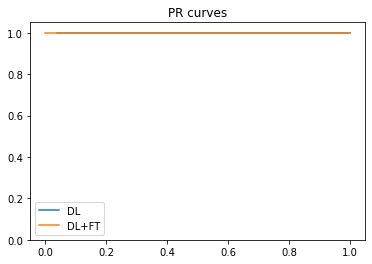

In [102]:
precision_dl_siam, recall_dl_siam, thresh_dl_siam = precision_recall_curve(genuine_id_dl_siam,scores_dl_siam)
plt.plot(recall_dl,precision_dl,label='DL');
plt.plot(recall_dl_siam,precision_dl_siam,label='DL+FT');
plt.legend();
plt.ylim([0,1.05])
plt.grid;
plt.title("PR curves");
auc_pr_dl_siam = auc(recall_dl_siam,precision_dl_siam)
print("Area Under the PR-curve (DL + FT):",auc_pr_dl_siam) #better than before

In [103]:
avg_precision_dl_siam = average_precision_score(genuine_id_dl_siam,scores_dl_siam)
print("Average precision score (DL + FT):",avg_precision_dl_siam) 
recogn_rates_dl_siam, rank_1_dl_siam = cumulative_matching_characteristic(dist_matrix_dl_siam)
print("Rank-1 RR (DL + FT):", rank_1_dl_siam)

Average precision score (DL + FT): 1.0
Rank-1 RR (DL + FT): 1.0
